In [1]:
%env XLA_PYTHON_CLIENT_PREALLOCATE=false

env: XLA_PYTHON_CLIENT_PREALLOCATE=false


In [1]:
import matplotlib.pyplot as plt

import jax.numpy as jnp
from jax.scipy.stats import norm
from jax import grad, jit, vmap
from jax import random as jrandom
import jax

from jax import config
config.update("jax_enable_x64", True)

from typing import Sequence, Tuple, Union, Optional
from jaxtyping import Array, ArrayLike, Float, Int, PyTree, PRNGKeyArray, ScalarLike

import equinox as eqx
import optax
import chex

import tensorflow as tf
# Ensure TF does not see GPU and grab all GPU memory.
tf.config.set_visible_devices([], device_type='GPU')

import tensorflow_datasets as tfds

from dataclasses import dataclass, astuple
from functools import partial

import numpy as np

jax.enable_checks = True

jax.devices()

2023-09-05 22:31:30.881079: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-09-05 22:31:32.042766: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


[gpu(id=0)]

# Payoff

In [2]:
class EuropeanPayoff:
    @staticmethod
    def call(maturity_prices: Float[ArrayLike, " n"], strike_prices: Float[ScalarLike, ""]) -> Float[Array, " n"]:
        return jnp.maximum(jnp.subtract(maturity_prices, strike_prices), 0.0)

    @staticmethod
    def put(maturity_prices: Float[ArrayLike, " n"], strike_prices: Float[ScalarLike, ""]) -> Float[Array, " n"]:
        return jnp.maximum(jnp.subtract(strike_prices, maturity_prices), 0.0)

    @staticmethod
    def payoff(spot_path, K, payoff_fn = call):
        spot_maturity = spot_path[..., -1]
        payoff = payoff_fn(spot_maturity, K)
        return payoff


def european_payoff(spot_path, K, payoff_fn = EuropeanPayoff.call):
    spot_maturity = spot_path[..., -1]
    payoff = payoff_fn(spot_maturity, K)
    return payoff

def european_payoff_and_deriv(spot_path, K, payoff_fn = EuropeanPayoff.call):
    spot_maturity = spot_path[..., -1]
    # payoff = payoff_fn(spot_maturity, K)
    payoff, dpayoff = jax.value_and_grad(payoff_fn)(spot_maturity, K)
    return payoff, dpayoff

# Heston

In [33]:

class ModelState(eqx.Module):
    S0: float
    v0: float

class Heston(eqx.Module):

    # S0: float = 100.0       # Initial spot price
    # K: float = 100.0        # Strike price
    # r: float = 0.0319       # Risk-free rate
    # v0: float = 0.010201    # Initial volatility
    # T: float = 1.00         # One year until expiry
    # rho: float = -0.7       # Correlation of asset and volatility
    # kappa: float = 6.21     # Mean-reversion rate
    # theta: float = 0.019    # Long run average volatility
    # xi: float = 0.61        # Volatility of volatility

    # European call option price is at 34.99 for the following config: 
    S0: float = 100.0       # Initial spot price
    K: float = 100.0        # Strike price
    r: float = 0.05         # Risk-free rate
    v0: float = 0.09        # Initial volatility
    T: float = 5.00         # n years until expiry, i.e. T2 - T1
    rho: float = -0.3       # Correlation of asset and volatility
    kappa: float = 2.00     # Mean-reversion rate
    theta: float = 0.09     # Long run average volatility
    xi: float = 1.00        # Volatility of volatility

    @property
    def model_state(self) -> ModelState:
        return ModelState(self.S0, self.v0)

def volatility_path(v0, vol_draws, self):
    n_iter = len(vol_draws)
    dt = self.T / n_iter

    def vol_path_iter(prev_vol_path, vol_draw):
        v_truncated = jnp.maximum(0.0, prev_vol_path)
        prev_path_contribution = prev_vol_path + self.kappa * dt * (self.theta - v_truncated)
        randomness = self.xi * jnp.sqrt(v_truncated * dt) * vol_draw
        current = prev_path_contribution + randomness
        return current, current # use current both for carry and for y

    carry, vol_path = jax.lax.scan(vol_path_iter, jnp.array(self.v0), vol_draws, length=n_iter)
    # jax.debug.print("vol_path {}", vol_path.shape)
    
    # we now have iteration 1 at position 0. Place initial v0 at the end and rotate into initial slot
    vol_path = jnp.roll(vol_path.at[-1].set(v0), 1)
    return vol_path


def spot_path(S0, self, spot_draws: Array, vol_path: Array) -> Array:
    n_iter = len(spot_draws)
    dt = self.T / n_iter

    def spot_path_iter(prev_spot_path, iter_pair):
        spot_draw = iter_pair[0]
        vol = iter_pair[1]
        v_truncated = jnp.maximum(0.0, vol)
        path_new_spot = prev_spot_path * jnp.exp((self.r - 0.5 * v_truncated) * dt + jnp.sqrt(v_truncated * dt) * spot_draw)
        return path_new_spot, path_new_spot

    iter_values = jnp.column_stack((spot_draws, vol_path))
    carry, spot_paths = jax.lax.scan(spot_path_iter, jnp.array(S0), iter_values, length=n_iter)
    # jax.debug.print("spot paths: {}", spot_paths)
    
    spot_paths = jnp.roll(spot_paths.at[-1].set(S0), 1)
    return spot_paths


def model_state_path(state: ModelState, self, vol_draws, spot_draws):
    vol_path = volatility_path(state.v0, vol_draws, self)
    s_path = spot_path(state.S0, self, spot_draws, vol_path)
    return s_path

def payoff(self, spot_path, payoff_fn = EuropeanPayoff.call):
    spot_maturity = spot_path[-1]
    payoff = payoff_fn(spot_maturity, self.K)
    return payoff

def path_and_payoff(state: ModelState, self, vol_draws, spot_draws):
    return payoff(self, model_state_path(state, self, vol_draws, spot_draws))

def correlated_draws(self: Heston, key, n_samples):
    mean = jnp.zeros(2)
    cov = jnp.array([[1.0, self.rho], [self.rho, 1.0]])

    correlated_samples = jrandom.multivariate_normal(key, mean, cov, shape=(n_samples,))

    vol_draws = correlated_samples[:, 0]
    spot_draws = correlated_samples[:, 1]
    return vol_draws, spot_draws

def path_fn(self: Heston, key: PRNGKeyArray, n_time_steps: int = 1000):
    # jax.debug.print("hest spots: {}", self.S0.shape)
    # jax.debug.print("hest vols: {}", self.v0.shape)
    # jax.debug.print("corr draws key: {}", key.shape)
    vol_draws, spot_draws = correlated_draws(self, key, n_time_steps)
    return path_and_payoff(self.model_state, self, vol_draws, spot_draws)

def differential_path(self: Heston, key: PRNGKeyArray, n_intervals: int = 1000):
    vol_draws, spot_draws = correlated_draws(self, key, n_intervals)
    p, dp = jax.value_and_grad(path_and_payoff)(self.model_state, self, vol_draws, spot_draws)
    return p, dp


In [4]:
key = jrandom.PRNGKey(0)
key, subkey = jrandom.split(key)
key, key_spots, key_vols = jrandom.split(subkey, 3)
n_samples = 100

initial_spots = jrandom.uniform(key_spots, shape=(n_samples,), minval=50, maxval=150)
initial_vols = jrandom.uniform(key_vols, shape=(n_samples,), minval=0.01, maxval=0.1)
# initial_spots = jnp.ones((n_samples)) * 100
# initial_vols = jnp.ones((n_samples)) * 0.09
h = Heston(S0=initial_spots, v0=initial_vols)
print(h)

Heston(
  S0=f64[100],
  K=100.0,
  r=0.05,
  v0=f64[100],
  T=5.0,
  rho=-0.3,
  kappa=2.0,
  theta=0.09,
  xi=1.0
)


# Skip


In [41]:
def heston_taker(h: Heston):
    rng = jrandom.PRNGKey(0)
    return path_fn(h, rng)

In [44]:
res = eqx.filter_vmap(heston_taker)(h)
print(res.shape)

(100,)


In [49]:
key, subkey = jrandom.split(key)
n_sims = 100

keys = jrandom.split(subkey, n_sims)
# keys = jnp.reshape(keys, (n_sims//n_samples, n_samples, 2))
print(len(keys))
print(keys.shape)

# res = jax.vmap(lambda x: eqx.filter_vmap(path_fn)(h, x))(keys)

# payoffs = eqx.filter_vmap(path_fn)(h, keys)

#payoffs = jax.vmap(eqx.filter_vmap(path_fn), in_axes=(None, 0))#(h, keys)
# payoffs = eqx.filter_vmap(eqx.filter_vmap(path_fn), in_axes=(None, 0))
# payoffs = eqx.filter_vmap(eqx.filter_vmap(path_fn), in_axes=(None, 0))

payoffs = jax.vmap(lambda x: eqx.filter_vmap(path_fn)(h, x))(keys)

print(payoffs)

# payoffs(h, keys)

# option_price = jnp.mean(payoffs, axis=0) * jnp.exp(-h.r * h.T)
# print(option_price.shape)
# print(option_price)


100
(100, 2)


ValueError: vmap got inconsistent sizes for array axes to be mapped:
  * most axes (2 of them) had size 100, e.g. axis 0 of argument _dynamic_args[0].S0 of type float64[100];
  * one axis had size 2: axis 0 of argument _dynamic_args[1] of type uint32[2]

In [87]:
key = jrandom.PRNGKey(0)
key, subkey = jrandom.split(key)
n_sims = 10000

keys = jrandom.split(subkey, n_sims)
keys = jnp.reshape(keys, (n_sims//n_samples, n_samples, 2))
print(len(keys))
print(keys.shape)

@jit
def option_price(h, keys):
    return jax.vmap(lambda k: eqx.filter_vmap(path_fn)(h, k))(keys)

def inner(h, k):
    res =  eqx.filter_vmap(path_fn)(h, k)
    print(res.shape)
    return res

#payoffs = jit(eqx.filter_vmap(partial(inner, h)))(keys) 
# res = option_price(h, keys)
payoffs = jax.vmap(lambda k: eqx.filter_vmap(path_fn)(h, k))(keys)
print(payoffs.shape)

# print(jnp.mean(res, axis=))
res = jnp.mean(payoffs, axis=0) * jnp.exp(-h.r * h.T)
print(res.shape)
print(res)


100
(100, 100, 2)
(100, 100)
(100,)
[26.14491736 47.23131959 29.84869553 38.08491958 33.03175936 30.21266902
 45.32301449 29.57048105 29.12291798 38.80504425 28.74904231 44.34363942
 31.97764956 32.48644494 39.28660562 42.63461245 35.53501534 54.10339934
 29.73836971 36.60067229 30.64719171 42.87891537 31.26578682 32.52510219
 34.90138395 44.08203845 31.12473287 35.18247349 39.5635788  38.9764712
 34.91492871 39.47289014 32.0727956  38.38633496 36.45425844 27.03558845
 31.91317162 42.50553563 34.67368298 33.50347796 36.32732915 39.59144137
 30.44176324 43.24410894 34.4963725  36.53700132 41.0167225  43.14132888
 40.03842159 33.92170827 43.44642325 23.68690673 31.93230527 33.60740013
 37.28394061 30.35718126 28.81876953 25.79701643 39.95621617 39.89883314
 36.34715449 36.98098142 33.56967079 29.75416847 46.86846385 41.37028599
 26.46462299 40.02382461 33.71580829 34.3566919  32.85867373 31.73014088
 35.44360501 29.51898512 34.58775278 42.1265726  30.20014292 37.6303917
 36.41752535 23.9

# Skip End

In [5]:
# the keys should be vmaped over in the inner loop

key = jrandom.PRNGKey(0)
key, subkey = jrandom.split(key)

# keys = jrandom.split(subkey, n_sims)
# keys = jnp.reshape(keys, (n_sims//n_samples, n_samples, 2))
# print(keys.shape)

@eqx.filter_jit
def inner(h, k, n_sims=100):

    # jax.debug.print("k.shape {}", k.shape)
    keys = jrandom.split(k, n_sims)
    res_fn = eqx.filter_vmap(path_fn, in_axes=(None, 0))
    # res = res_fn(h, keys)
    # print("inner: ", res.shape)
    res = jnp.sum(res_fn(h, keys))
    return res

print(inner)

@eqx.filter_jit
def option_price(key, h: Heston, n_sims=100):
    print(n_sims)
    payoffs_fn = eqx.filter_vmap(partial(inner, n_sims=n_sims))
    
    keys = jrandom.split(key, n_samples)
    # payoffs = payoffs_fn(h, keys) 
    price = jnp.divide(payoffs_fn(h, keys), n_sims) * jnp.exp(-h.r * h.T)
    return price
    # print(option_price)


# payoffs = eqx.filter_vmap(inner)(h, keys)

# res = option_price(h, keys)
# payoffs = jax.vmap(lambda x: eqx.filter_vmap(path_fn)(x, keys))(h)
# print(payoffs.shape)
# print(payoffs)

# res = jnp.mean(payoffs, axis=0) * jnp.exp(-h.r * h.T)
# print(res.shape)
# print(res)

_JitWrapper(
  _signature=<Signature (h, k, n_sims=100)>,
  _dynamic_fun=(None,),
  _static_fun=((<function inner>,), PyTreeDef(*)),
  _cached=<wrapped function inner>,
  _filter_warning=False
)


In [7]:
key = jrandom.PRNGKey(14)
key, subkey = jrandom.split(key)
p = option_price(subkey, h, n_sims=1000)
print(p)


[53.68312564 12.82611783 60.11843259 27.90819224  7.5578509  12.69977222
 18.9184155  15.79041019  9.95087594 67.3627215  22.9944182   8.93024759
 26.68806956 80.40655786 46.33648592 21.69975355 69.19845306 11.99202607
  8.23043529 25.94771899  5.0025849  22.27449344 79.79302597  4.76836628
 79.08308218 41.98236765 65.29282201 63.22087894 30.07977053  5.6780378
 44.59605904 47.30632262 74.71247079 19.21040726 79.57511275 70.04405186
 25.20040173 76.84361154 15.1863805  35.37995476 75.13598161 29.83231559
 51.40228188 16.56853652 85.79227663 25.70851187 11.72201708 30.3947746
 29.636496   63.35139637 14.34782556  4.83581763 20.18193716 50.33068014
 19.52022061 42.36350244 49.29030786  9.9774233   5.44017026 58.46892863
 29.39184954 69.21610174 39.44857126 45.59854354 77.08002246 10.02901575
 58.62647572 13.45497992 66.29102053 64.63939517 46.35682863 36.42537201
 42.84577367 66.66123183 21.03676535 11.25095805 17.36024571 36.45894594
 62.68612062 70.64289413 33.73120434 60.24317261 14.1

In [32]:
key = jrandom.PRNGKey(14)
key, subkey = jrandom.split(key)
n_sims = 10000

keys = jrandom.split(subkey, n_sims)
keys = jnp.reshape(keys, (n_sims//n_samples, n_samples, 2))
print(len(keys))
print(keys.shape)


# def map_reduce(payoff_sum, key):
#     # print("inner keys shape:", key.shape)

#     keys = jrandom.split(key, n_samples)
#     # res = eqx.filter_vmap(path_fn)(h, keys)
#     res = jax.vmap(lambda x: eqx.filter_vmap(path_fn)(h, x))(keys)
#     print("inner shape:", res.shape)


#     payoff_sum_iter = jnp.sum(res)
#     # jax.debug.print("payoff sum iter {}", payoff_sum_iter)
#     payoff_sum += payoff_sum_iter
#     return payoff_sum, None


# res, _ = jax.lax.scan(map_reduce, jnp.zeros(n_samples), keys)

# res = jax.vmap(map_reduce)(keys)
# res = jax.vmap(lambda hes: jnp.sum(eqx.filter_vmap(path_fn)(
# res /= n_samples
# res *= jnp.exp(-h.r * h.T)
# res = jnp.reshape(res, n_sims)

res = jax.vmap(lambda x: eqx.filter_vmap(path_fn)(h, x))(keys)
res = jnp.mean(res, axis=0) * jnp.exp(-h.r * h.T)
print(res.shape)
print(res)

@eqx.filter_jit
def option_price2(key, h: Heston, n_sims=100):
    n_samples = h.S0.shape[0]
    # print(n_samples)
    keys = jrandom.split(key, n_sims)
    keys = jnp.reshape(keys, (n_sims//n_samples, n_samples, 2))
    
    payoffs = jax.vmap(lambda x: eqx.filter_vmap(path_fn)(h, x))(keys)
    price = jnp.mean(payoffs, axis=0) * jnp.exp(-h.r * h.T)
    return price


@eqx.filter_jit
def option_price_scalar(key, h: Heston, n_sims=1000):
    keys = jrandom.split(key, n_sims)
    payoffs = eqx.filter_vmap(path_fn)(h, keys)
    price = jnp.mean(payoffs) * jnp.exp(-h.r * h.T)

    return price
    
# prices = price(subkey, h)
# jax.debug.print("prices {}", prices)

100
(100, 100, 2)
(100,)
[37.81256843 22.04786996 37.55133611 34.92675187 34.56824155 27.21316132
 37.17313091 24.11844619 39.78846741 39.70811048 36.11527004 43.23566221
 24.66425883 28.52708729 40.23364058 43.72967254 35.88441175 36.47992506
 29.32520632 36.94136245 32.87474896 25.99350726 33.42104167 29.79107148
 40.41444909 36.09003734 34.33543428 46.43330989 36.07994496 37.54866645
 35.64752103 34.30788526 40.56181088 33.52279533 33.42634042 34.86181821
 28.08686716 44.04751362 30.14637188 41.69635703 40.33799109 37.41006508
 40.63947838 32.00416117 40.15166969 33.32239684 29.89655277 24.34914492
 40.12602923 35.27280036 31.69680405 42.03900563 29.60533002 33.00306454
 33.45034692 40.24551239 38.88392898 36.12936368 31.22096523 44.84228899
 44.61061017 36.05050116 32.25775658 36.18157432 32.98510132 35.12682356
 41.35830329 25.15859584 24.58743672 31.11437929 37.5774385  36.29794513
 37.09185645 41.29122341 32.18527267 38.47174819 33.81899028 29.12047264
 25.46350502 39.00088697 3

In [10]:
# key = jrandom.PRNGKey(14)
key, subkey = jrandom.split(key)
%timeit p = option_price2(subkey, h, n_sims=10000)
print(p)
print(jnp.mean(p))

53.1 ms ± 1.77 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
[53.68312564 12.82611783 60.11843259 27.90819224  7.5578509  12.69977222
 18.9184155  15.79041019  9.95087594 67.3627215  22.9944182   8.93024759
 26.68806956 80.40655786 46.33648592 21.69975355 69.19845306 11.99202607
  8.23043529 25.94771899  5.0025849  22.27449344 79.79302597  4.76836628
 79.08308218 41.98236765 65.29282201 63.22087894 30.07977053  5.6780378
 44.59605904 47.30632262 74.71247079 19.21040726 79.57511275 70.04405186
 25.20040173 76.84361154 15.1863805  35.37995476 75.13598161 29.83231559
 51.40228188 16.56853652 85.79227663 25.70851187 11.72201708 30.3947746
 29.636496   63.35139637 14.34782556  4.83581763 20.18193716 50.33068014
 19.52022061 42.36350244 49.29030786  9.9774233   5.44017026 58.46892863
 29.39184954 69.21610174 39.44857126 45.59854354 77.08002246 10.02901575
 58.62647572 13.45497992 66.29102053 64.63939517 46.35682863 36.42537201
 42.84577367 66.66123183 21.03676535 11.25095805 17.36024

# Test scenarios

from:
https://www.researchgate.net/publication/220243902_Exact_Simulation_of_Stochastic_Volatility_and_Other_Affine_Jump_Diffusion_Processes

and: 
https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1718102


In [71]:
def mse(y_pred, y_true):
    return jnp.mean((jnp.array(y_pred) - jnp.array(y_true))**2)

def rmse(y_pred, y_true):
    return jnp.sqrt(mse(y_pred, y_true))

def test_heston(key, h: Heston, true_price: float):
    key, subkey = jrandom.split(key)
    p_h = option_price_scalar(subkey, h, n_sims=100000)
    rmse_h = rmse(p_h, true_price)
    jax.debug.print("sim price: {:.4f} vs true price: {:.4f} | rmse: {:.4f}", p_h, true_price, rmse_h)
    return p_h, rmse_h2   

# https://www.researchgate.net/publication/220243902_Exact_Simulation_of_Stochastic_Volatility_and_Other_Affine_Jump_Diffusion_Processes
h1 = Heston(S0=100.0, v0=0.09)
h1_true_price = 34.9998

h2 = Heston(
    S0 = 100.0,       
    K = 100.0,   
    r = 0.0319,
    v0 = 0.010201, 
    T = 1.0,
    rho = -0.7,
    kappa = 6.21,
    theta = 0.019,
    xi = 0.61,
)
h2_true_price = 6.8061

# https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1718102
h3 = Heston(
    S0 = 100.0,       
    K = 100.0,   
    r = 0.00,
    v0 = 0.04, 
    T = 1.0,
    rho = -0.9,
    kappa = 0.5,
    theta = 0.04,
    xi = 1.00,
)
h3_true_price = 4.403

h4 = Heston(
    S0 = 100.0,       
    K = 100.0,   
    r = 0.00,
    v0 = 0.04, 
    T = 1.0,
    rho = -0.5,
    kappa = 0.3,
    theta = 0.04,
    xi = 0.9,
)
h4_true_price = 5.100

key = jrandom.PRNGKey(0)
key, key_h1, key_h2, key_h3, key_h4, key_h5 = jrandom.split(key, 6)
test_heston(key_h1, h1, h1_true_price)
test_heston(key_h2, h2, h2_true_price)
test_heston(key_h3, h3, h3_true_price)
test_heston(key_h4, h3, h3_true_price)
test_heston(key_h3, h3, h3_true_price)

sim price: 34.9138 vs true price: 34.9998 | rmse: 0.0860
sim price: 6.7791 vs true price: 6.8061 | rmse: 0.0270
sim price: 4.3964 vs true price: 4.4030 | rmse: 0.0066


(Array(4.39636587, dtype=float64), Array(0.02579761, dtype=float64))

In [66]:
# for smoothing the heston use: https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1718102
# page 18

# Pricing example

In [22]:
# Price calculation of heston model on european call option
#@eqx.filter_jit
def price(key, heston: Heston):
    n_multiplier = 1
    n_simulations = 10000 * n_multiplier
    n_outside_iter = 10 * n_multiplier
    n_sims_per_iter = n_simulations // n_outside_iter
    payoff_sum: float = 0.0
    n_states = heston.S0.shape[0]

    if n_simulations % n_states:
        raise ValueError("n_states must be divisor of 1000")
    
    def pathwise_payoff_fn(payoff_sum, key):
        #print("Payoff sum shape", payoff_sum.shape)
        keys_path = jrandom.split(key, num=n_sims_per_iter)
        keys_path = jnp.reshape(keys_path, (n_sims_per_iter//n_states, n_states, 2))
        
        res = jax.vmap(lambda x: eqx.filter_vmap(path_fn)(heston, x))(keys_path)
        pathwise_payoff = jnp.reshape(res, n_sims_per_iter)
        
        jax.debug.print("keys_path.shape {}", keys_path.shape)
        # pathwise_payoff = vmap(heston.payoff)(keys)

        # fn = eqx.filter_vmap(differential_path)
        # pathwise_payoff, grads = fn(heston, keys_path)
        # pathwise_payoff = eqx.filter_vmap(partial(path, heston))(keys_path)

        # map_over_inits = lambda key: eqx.filter_vmap(partial(path_fn, key=key))(heston)
        # pathwise_payoff = jax.vmap(map_over_inits)(keys_path)
        # pathwise_payoff = eqx.filter_vmap(path_fn)(heston, keys_path)
        
        
        # map_over_keys = lambda h: jax.vmap(partial(path, h))(keys_path)
        # pathwise_payoff = eqx.filter_vmap(map_over_keys)(heston)

        # pathwise_payoff = map_over_inits(jrandom.PRNGKey(4))
        
        print("pathwise payoff", pathwise_payoff.shape)
        # jax.debug.print("pathwise payoff: {}", pathwise_payoff)
        
        payoff_sum_iter = jnp.sum(pathwise_payoff, axis=0)
        # jax.debug.print("payoff sum iter {}", payoff_sum_iter)
        payoff_sum += payoff_sum_iter
        # jax.debug.print("payoff_sum: {}", payoff_sum)
        return payoff_sum, payoff_sum_iter

    keys = jrandom.split(key, num=n_outside_iter)

    # print("heston.n_states: :", n_states)
    payoff_sum, _ = jax.lax.scan(pathwise_payoff_fn, jnp.zeros(n_states), keys, length=n_outside_iter)
    print(payoff_sum)
    option_price = (payoff_sum / n_simulations) * jnp.exp(-heston.r * heston.T)
    return option_price


In [23]:
key = jrandom.PRNGKey(0)
key, subkey = jrandom.split(key)
key, key_spots, key_vols = jrandom.split(subkey, 3)
n_samples = 5

initial_spots = jrandom.uniform(key_spots, shape=(n_samples,), minval=50, maxval=150)
initial_vols = jrandom.uniform(key_vols, shape=(n_samples,), minval=0.01, maxval=0.1)
initial_spots = jnp.ones(n_samples) * 100
initial_vols = jnp.ones(n_samples) * 0.09
h = Heston(S0=initial_spots, v0=initial_vols)

key, subkey = jrandom.split(key)
prices = price(subkey, h)
jax.debug.print("prices {}", prices)

pathwise payoff (1000,)
keys_path.shape (array(200), array(5), array(2))
keys_path.shape (array(200), array(5), array(2))
keys_path.shape (array(200), array(5), array(2))
keys_path.shape (array(200), array(5), array(2))
keys_path.shape (array(200), array(5), array(2))
keys_path.shape (array(200), array(5), array(2))
keys_path.shape (array(200), array(5), array(2))
keys_path.shape (array(200), array(5), array(2))
keys_path.shape (array(200), array(5), array(2))
keys_path.shape (array(200), array(5), array(2))
[448928.41084707 448928.41084707 448928.41084707 448928.41084707
 448928.41084707]
prices [34.96257979 34.96257979 34.96257979 34.96257979 34.96257979]


In [45]:
n_samples = 1000
key = jrandom.PRNGKey(4)
key, key_spots, key_vols = jrandom.split(key, 3)
initial_spots = jrandom.uniform(key_spots, shape=(n_samples,), minval=50, maxval=150)
initial_vols = jrandom.uniform(key_vols, shape=(n_samples,), minval=0.01, maxval=0.1)
heston = Heston(S0=initial_spots, v0=initial_vols)

key, subkey = jrandom.split(key)
key_rngs = jrandom.split(subkey, n_samples)
ps, dps = eqx.filter_vmap(differential_path)(heston, key_rngs)

payoff_sum = jnp.sum(ps)
option_price = (payoff_sum / len(ps)) * jnp.exp(-heston.r * heston.T)


print("payoffs: ", ps)
print("dps S0: ", dps.S0)
print("dps v0: ", dps.v0)
print("option price: ", option_price)

vol_path  (1000,)
payoffs:  [1.42159743e+02 1.94206344e+02 0.00000000e+00 2.45306931e+01
 0.00000000e+00 0.00000000e+00 1.29382244e+02 1.01702036e+02
 0.00000000e+00 0.00000000e+00 4.70082505e+00 6.46374112e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.13045055e+01
 0.00000000e+00 2.44789227e+00 0.00000000e+00 1.22531922e+01
 1.29007165e+02 0.00000000e+00 6.32113829e+01 1.67494691e+02
 5.50776658e+00 0.00000000e+00 0.00000000e+00 1.10195018e+02
 1.95771984e+02 0.00000000e+00 0.00000000e+00 3.05951605e+01
 7.39941957e+01 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.53261269e+00 2.13141489e+01 0.00000000e+00 0.00000000e+00
 2.70830607e+01 0.00000000e+00 5.45644654e+01 1.57300932e+01
 0.00000000e+00 7.31308795e+00 0.00000000e+00 7.58935281e+01
 0.00000000e+00 0.00000000e+00 2.42154100e+02 0.00000000e+00
 0.00000000e+00 9.28760737e+01 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 9.93442171e+01
 1.50701942e+02 8.54623534e+00 0.00000000e+00 0.00000000e

# Pathwise Differential Data

In [ ]:
n_samples = 1024
key = jrandom.PRNGKey(4)
key, key_spots, key_vols = jrandom.split(key, 3)
initial_spots = jrandom.uniform(key_spots, shape=(n_samples,), minval=50, maxval=150)
initial_vols = jrandom.uniform(key_vols, shape=(n_samples,), minval=0.01, maxval=0.1)
hs = Heston(S0=initial_spots, v0=initial_vols)

key, subkey = jrandom.split(key)
key_rngs = jrandom.split(subkey, n_samples)
ps, dps = eqx.filter_vmap(differential_path_fn)(hs, key_rngs)

print("payoffs: ", ps)
print("dps S0: ", dps.S0)
print("dps v0: ", dps.v0)

In [21]:
n_samples = 1024
key = jrandom.PRNGKey(4)
key, key_spots, key_vols = jrandom.split(key, 3)
initial_spots = jrandom.uniform(key_spots, shape=(n_samples,), minval=50, maxval=150)
initial_vols = jrandom.uniform(key_vols, shape=(n_samples,), minval=0.01, maxval=0.1)
hs = Heston(S0=initial_spots, v0=initial_vols)

key, subkey = jrandom.split(key)
key_rngs = jrandom.split(subkey, n_samples)
ps, dps = eqx.filter_vmap(differential_path)(hs, key_rngs)

print("payoffs: ", ps)
print("dps S0: ", dps.S0)
print("dps v0: ", dps.v0)

payoffs:  [  0.          90.05131403 102.89837325 ...   0.          36.75760451
  71.81945574]
dps S0:  [0.         1.67235479 1.38854521 ... 0.         0.94857642 1.47786596]
dps v0:  [  0.          33.70999708  49.71692937 ...   0.         -41.6370594
  36.96054858]


dpayoff/dS0
dpayoff/dv0


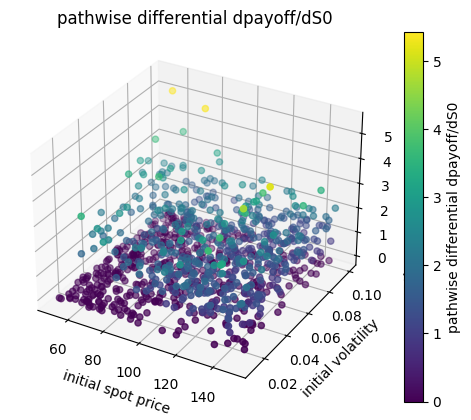

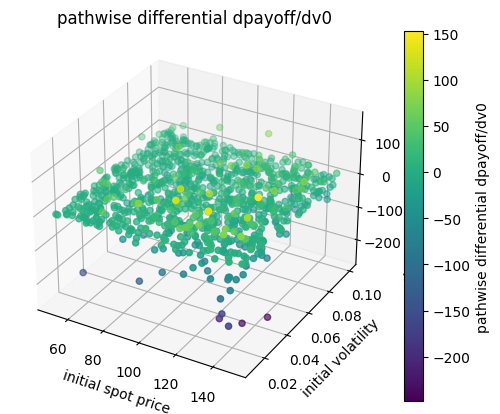

In [22]:
def plot_differential_data(init_spots, init_vols, payoffs, states: ModelState):
    # plt.plot(init_spots, payoffs, 'b.', markersize=1.0, label = 'payoffs')
    plt.plot(init_spots, states.S0, 'r.', markersize=1.0, label = 'dpayoff/dS0')

    print(init_spots.shape)
    print(states.S0.shape)
    # plt.plot(init_spots, states
    # plt.plot(hset.initial_spot_prices, prices, 'r.', markersize=3, label='price')
    plt.legend()
    plt.xlabel('initial spot price')
    plt.ylabel('payoff')
    # plt.ylim(-1, 1000)
    plt.show()

def plot_3d_differential_data(init_spots, init_vols, differential_data, label):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    # ax.plot_trisurf(hset.initial_spot_prices, hset.initial_vols, prices, linewidth=0.2)
    sc = ax.scatter(init_spots, init_vols, differential_data, c=differential_data, cmap=plt.cm.viridis)
    
    # Add a colorbar to show the mapping of colors to z-values
    cbar = fig.colorbar(sc)
    cbar.set_label(label)
    
    ax.set_title(label)
    ax.set_xlabel("initial spot price")
    ax.set_ylabel("initial volatility")
    ax.set_zlabel(label)
    return fig

print("dpayoff/dS0")
fig = plot_3d_differential_data(initial_spots, initial_vols, dps.S0, "pathwise differential dpayoff/dS0")

print("dpayoff/dv0")
fig = plot_3d_differential_data(initial_spots, initial_vols, dps.v0, "pathwise differential dpayoff/dv0")